In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import itertools

In [2]:
온라인 = pd.read_csv('01.온라인 행동 정보.csv', encoding='utf-8')
온라인 = 온라인.sort_values(['clnt_id','sess_id','hit_seq']).reset_index(drop=True)
온라인.shape

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(3196362, 14)

In [3]:
온라인['unique_id'] = list(map(lambda x,y: str(x)+'_'+str(y), 온라인.clnt_id, 온라인.sess_id))
온라인.head()

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,unique_id
0,1,1,1,0,A01,20190911,16:14,11880,NaN,과일선물세트,14.0,124.0,unknown,mobile_app,1_1
1,1,1,2,0,A01,20190911,16:15,22432,NaN,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,1_1
2,1,1,3,0,A01,20190911,16:15,36140,NaN,과일바구니,14.0,124.0,unknown,mobile_app,1_1
3,1,2,1,0,A01,20190922,14:09,41584,NaN,초등가을잠바,45.0,424.0,unknown,mobile_app,1_2
4,1,2,2,0,A01,20190922,14:10,56113,NaN,초등가을점퍼,45.0,424.0,unknown,mobile_app,1_2


In [5]:
온라인.groupby('unique_id').biz_unit.nunique().describe()

count    367149.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: biz_unit, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


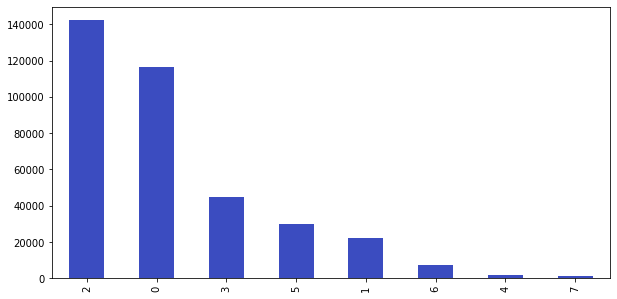

In [122]:
plt.figure(figsize=(10,5))
온라인[온라인.hit_seq == 1].action_type.value_counts().plot('bar')
plt.show()

In [4]:
# 온라인 고객: 72,399명, 고객 및 세션: 367,149개
온라인.clnt_id.nunique(), 온라인.unique_id.nunique()

(72399, 367149)

In [6]:
# 각 clnt_id별 session이 바뀌는 지점 index 저장
idx1 = 온라인.unique_id.drop_duplicates().index.tolist()
idx2 = idx1[1:] + [len(온라인)]

In [7]:
# session별 체류시간 = 다음 hit_pss_tm - 이전 hit_pss_tm
stay_tm = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.iloc[i:j].hit_pss_tm
    if len(temp) == 1:
        stay_tm.append(temp.tolist())
    else:
        temp = temp.diff().tolist()[1:]
        temp.append(temp[-1]) # 마지막은 해당 hit_pss_tm 값 사용
        stay_tm.append(temp)
    #stay_tm = stay_tm + 온라인.iloc[i:j].hit_pss_tm.diff().fillna(0).tolist()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
#stay_tm = sum(stay_tm, []) # 시간 매우 오래걸림
온라인['time_length'] = list(itertools.chain.from_iterable(stay_tm))

In [9]:
# 밀리초->초 변환
온라인['hit_pss_tm'] = np.ceil(온라인['hit_pss_tm']/1000)
온라인['time_length'] = np.ceil(온라인['time_length']/1000)

In [10]:
# 주말 및 공휴일 여부
holiday_diff = []
for i in 온라인.sess_dt.map(lambda x: str(x)[-3:]).tolist():
    if i in (['706','707','713','714','717','720','721','727','728',
               '803','804','810','811','815','817','818','824','825',
               '907','908','912','913','914','915','921','922','928','929']):
        holiday_diff.append(1)
    else:
        holiday_diff.append(0)
온라인['holiday_diff'] = holiday_diff

In [11]:
# keyword: session별 sech_kwd의 cumulative sum
온라인['sech_kwd'] = 온라인.sech_kwd.map(lambda x: 0 if str(x) == 'nan' else 1)
keyword = []
for i, j in tqdm_notebook(zip(idx1, idx2), total=len(idx1)):
    temp = 온라인.iloc[i:j].sech_kwd
    keyword.append(np.cumsum(temp.tolist()))
온라인['keyword'] = list(itertools.chain.from_iterable(keyword))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [12]:
온라인['sess_dt'] = 온라인['sess_dt'].map(lambda x: str(x)[:-2]) # day제거하고 month(7,8,9월)만 남김
온라인['dvc_ctg_nm'].fillna('unknown',inplace=True) # device null값을 unknown으로 대체

# dummy variable 생성 - action_type, biz_unit, sess_dt, trfc_src, dvc_ctg_nm
온라인 = pd.concat([온라인, pd.get_dummies(온라인[['biz_unit','sess_dt','trfc_src','dvc_ctg_nm']])], axis=1) # sensitivy analysis 위해서 drop_first=False 사용
온라인 = pd.concat([온라인, pd.get_dummies(온라인.action_type, prefix='action_type')], axis=1) # drop_fist=False
온라인 = 온라인.drop(['action_type','biz_unit','sess_dt','hit_tm','sech_kwd','tot_pag_view_ct', 'tot_sess_hr_v','trfc_src','dvc_ctg_nm'], axis=1)

In [13]:
온라인 = 온라인[['clnt_id', 'sess_id', 'trans_id', 'hit_seq', 'hit_pss_tm', 'time_length', 'holiday_diff', 'keyword',
                'action_type_0', 'action_type_1', 'action_type_2', 'action_type_3','action_type_4', 'action_type_5', 'action_type_6', 'action_type_7',
                'biz_unit_A01', 'biz_unit_A02', 'biz_unit_A03', 'sess_dt_201907', 'sess_dt_201908', 'sess_dt_201909', 
                'trfc_src_DIRECT', 'trfc_src_PORTAL_1', 'trfc_src_PORTAL_2', 'trfc_src_PORTAL_3', 'trfc_src_PUSH', 'trfc_src_WEBSITE', 'trfc_src_unknown', 
                'dvc_ctg_nm_PC', 'dvc_ctg_nm_mobile_app','dvc_ctg_nm_mobile_web', 'dvc_ctg_nm_unknown', 'unique_id']]

In [14]:
# 각 hit_seq 당 action_type이 구매완료=1, 이외=0
온라인['buy'] = 온라인['action_type_6']
온라인 = 온라인.drop(['action_type_5', 'action_type_6', 'action_type_7'], axis=1)
print(온라인.shape)
온라인.head()

(3196362, 32)


,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_0,action_type_1,...,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_PC,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id,buy
0,1,1,NaN,1,12.0,11.0,0,1,1,0,...,0,0,0,1,0,1,0,0,1_1,0
1,1,1,NaN,2,23.0,14.0,0,2,1,0,...,0,0,0,1,0,1,0,0,1_1,0
2,1,1,NaN,3,37.0,14.0,0,3,1,0,...,0,0,0,1,0,1,0,0,1_1,0
3,1,2,NaN,1,42.0,15.0,1,1,1,0,...,0,0,0,1,0,1,0,0,1_2,0
4,1,2,NaN,2,57.0,14.0,1,2,1,0,...,0,0,0,1,0,1,0,0,1_2,0


In [15]:
온라인.columns

Index(['clnt_id', 'sess_id', 'trans_id', 'hit_seq', 'hit_pss_tm',
       'time_length', 'holiday_diff', 'keyword', 'action_type_0',
       'action_type_1', 'action_type_2', 'action_type_3', 'action_type_4',
       'biz_unit_A01', 'biz_unit_A02', 'biz_unit_A03', 'sess_dt_201907',
       'sess_dt_201908', 'sess_dt_201909', 'trfc_src_DIRECT',
       'trfc_src_PORTAL_1', 'trfc_src_PORTAL_2', 'trfc_src_PORTAL_3',
       'trfc_src_PUSH', 'trfc_src_WEBSITE', 'trfc_src_unknown',
       'dvc_ctg_nm_PC', 'dvc_ctg_nm_mobile_app', 'dvc_ctg_nm_mobile_web',
       'dvc_ctg_nm_unknown', 'unique_id', 'buy'],
      dtype='object')

In [16]:
len(온라인.columns)

32

In [24]:
# 저장하고 가자
온라인.to_csv('온라인_전처리_final_32columns.csv', index=False)

In [3]:
온라인 = pd.read_csv('온라인_전처리_final_32columns.csv')
print(온라인.shape)
온라인.head()

(3196362, 32)


,clnt_id,sess_id,trans_id,hit_seq,hit_pss_tm,time_length,holiday_diff,keyword,action_type_0,action_type_1,...,trfc_src_PORTAL_3,trfc_src_PUSH,trfc_src_WEBSITE,trfc_src_unknown,dvc_ctg_nm_PC,dvc_ctg_nm_mobile_app,dvc_ctg_nm_mobile_web,dvc_ctg_nm_unknown,unique_id,buy
0,1,1,NaN,1,12.0,11.0,0,1,1,0,...,0,0,0,1,0,1,0,0,1_1,0
1,1,1,NaN,2,23.0,14.0,0,2,1,0,...,0,0,0,1,0,1,0,0,1_1,0
2,1,1,NaN,3,37.0,14.0,0,3,1,0,...,0,0,0,1,0,1,0,0,1_1,0
3,1,2,NaN,1,42.0,15.0,1,1,1,0,...,0,0,0,1,0,1,0,0,1_2,0
4,1,2,NaN,2,57.0,14.0,1,2,1,0,...,0,0,0,1,0,1,0,0,1_2,0
